# EEG analysis - part 2

This work is split into coherent, independent parts to keep the notebooks less memory hungry.

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, svm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import os
import Queue
import sys
import tarfile
import gzip
import pandas
import random
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot
import nolds

from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning) 

%matplotlib inline

## Train a CNN

Create a database of recurrence plots on the selection of the most important coefficients found in the previous question and train a CNN using those channels.

I thought that DBNs should be more effective on this task, because a DBN learns to associate features with location it appeared in, but the literature seems to suggest otherwise. Maybe we can try CDBNs, and/or CapsNets.

We have a lot of complex data and can therefore afford many parameters in our architecture. On the other hand, training time might be an issue when fine-tuning the hyperparameters, even using an efficient Bayesian search method. It might be a good idea therefore, to use a cloud service for distributed hyperparameter search.

Hyperparameter search is easier to configure in Keras than in TF. This is however just a prototype test.

However, there are simpler approaches which might work well, too, like pre-processing the dataset to reduce the dimensionality, and others.

Let's start by creating a pickable datase of 2D arrays from the dataset.

In [27]:
channels = ['FP2', 'CZ', 'T4', 'C1', 'O2']

def load_rps_from_folder(foldername, numfolders=1):
    q = Queue.Queue()
    q.put(foldername)
    cols = ['subject', 'channel', 'rec_plot', 'label']
    df_res = pd.DataFrame(columns=cols)
    
    while not q.empty():
        foldername = q.get()
        for item in os.listdir(foldername):
            item = os.path.join(foldername, item)
            if os.path.isdir(item):
                print('Queueing folder %s' % item)        
                q.put(item)
            elif item.endswith('.gz'):
                print('Skipping zipped file %s' % item)
            elif os.path.isfile(item):
                print('Processing file %s' % item)
                if os.stat(item).st_size == 0:
                    continue
                no_ext_name = os.path.splitext(os.path.splitext(item)[0])[0]
                subject = no_ext_name[-8] + no_ext_name[-3:]
                df_file = pd.read_table(item, skiprows=5, names=['chan', 'ind', 'val'], \
                                       delim_whitespace=True, usecols=range(1,4), comment='#')
                try:
                    for key, group in df_file.groupby('chan'):
                        # Pick electrodes far apart with preference to right hemisphere (ass. w\ depression)
                        if key not in channels:
                            continue
                        ts = (df_file.loc[df_file['chan'] == key]['val'].values)
                        rp = RecurrencePlot(ts, threshold=0.1)
                        d = {
                            'subject': subject,
                            'channel': key,
#                             'rec_plot': rp,
                            'rec_plot': [rp.distance_matrix([[30],[30]], 'manhattan').ravel()],
    #                         'rec_plot': pd.Series(list(rp.recurrence_matrix()), dtype=float), # TODO: find a way to convert to a float to plot
                            'label': no_ext_name[-8]
                        }
                        new_row = pd.DataFrame(d, columns=cols, index=[0])
                        df_res = df_res.append(new_row, ignore_index=True)
                except Exception as e:
                    print("Skipping processing file %s - exception raised: %s" % (item, str(e)))
                    continue
            else:
                raise Exception("Unexpected file %s, this should not happen" % item)
                
    return df_res

df_test = load_rps_from_folder('SMNI_CMI_TEST')
df_train = load_rps_from_folder('SMNI_CMI_TRAIN')

Queueing folder SMNI_CMI_TEST/co2c0000344
Queueing folder SMNI_CMI_TEST/co2a0000377
Processing file SMNI_CMI_TEST/README
Queueing folder SMNI_CMI_TEST/co2c0000346
Queueing folder SMNI_CMI_TEST/co2a0000370
Queueing folder SMNI_CMI_TEST/co2a0000378
Queueing folder SMNI_CMI_TEST/co2c0000342
Queueing folder SMNI_CMI_TEST/co2a0000368
Queueing folder SMNI_CMI_TEST/co2c0000341
Queueing folder SMNI_CMI_TEST/co2a0000375
Queueing folder SMNI_CMI_TEST/co2c0000340
Queueing folder SMNI_CMI_TEST/co2a0000364
Queueing folder SMNI_CMI_TEST/co2c0000339
Queueing folder SMNI_CMI_TEST/co2a0000369
Queueing folder SMNI_CMI_TEST/co2c0000337
Queueing folder SMNI_CMI_TEST/co2c0000345
Queueing folder SMNI_CMI_TEST/co2a0000372
Queueing folder SMNI_CMI_TEST/co2a0000365
Queueing folder SMNI_CMI_TEST/co2c0000347
Queueing folder SMNI_CMI_TEST/co2c0000338
Queueing folder SMNI_CMI_TEST/co2a0000371
Processing file SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.052
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.077
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.042
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co

Processing file SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.089
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.087
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.040
Calculating recurrence plot at fixed threshold...
Calculating the

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.050
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.057
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.046
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co

Processing file SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.036
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.053
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.069
Calculating recurrence plot at fixed threshold...
Calculating the

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.053
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.045
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.055
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000342/co2c0000342.rd.077
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000342/co2c0000342.rd.079
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000368/co2a0000368.rd.051
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000368/co2a0000368.rd.057
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.063
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.030
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.067
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000375/co2a0000375.rd.045
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000375/co2a0000375.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.076
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.045
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.098
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.094
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000364/co2a0000364.rd.036
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000364/co2a0000364.rd.103
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.073
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.022
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.083
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.032
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.048
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.097
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.077
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.038
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co

Processing file SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.081
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.097
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.039
Calculating recurrence plot at fixed threshold...
Calculating the

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.079
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.036
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.083
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.087
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.103
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.093
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.117
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.095
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.061
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.091
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Processing file SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.039
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.040
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000371/co2a0000371.rd.053
Calculating recurrence plot at fixed threshold...
Calculating the

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000371/co2a0000371.rd.055
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/co2a0000371/co2a0000371.rd.075
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at f

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.075
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.047
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.000
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.037
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.030
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.014
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.005
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.018
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.001
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Processing file SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.051
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.005
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.015
Calculating recurrence plot at fixed threshold...
Calculating 

Processing file SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.005
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.011
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.033
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.047
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.010
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.020
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.007
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum dista

Processing file SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.017
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.000
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.021
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.000
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.064
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.025
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.057
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Processing file SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.037
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.053
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.065
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.039
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.010
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.027
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.024
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.016
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.047
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.004
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.019
Calculating recurr

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.027
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Processing file SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.016
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.007
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.000
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.047
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN

Processing file SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.022
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.077
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.000
Calculating recurrence plot at fixed threshold...
Calculating 

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.005
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.014
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.023
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.014
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.021
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.000
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.018
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN

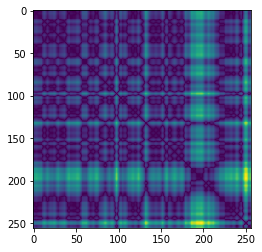

In [29]:
# Here is how to unravel the matrix
matrix = df_test.iloc[1]['rec_plot']
matrix.resize((256, 256))
plt.imshow(matrix)
plt.show()

In [30]:
df_test.to_pickle('rps_test.pickle')
df_train.to_pickle('rps_train.pickle')

In [ ]:
image_size = 256
batch_size = 16
beta = 0.9
learning_rate = 0.001
num_channels = len(channels)
num_labels = 2

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0, trainable=False)
    
    # Variables
    c1_w = tf.Variable(tf.truncated_normal([3, 3, num_channels, 16], stddev=0.1))
    c1_b = tf.Variable(tf.zeros([16]))
    
    c2_w = tf.Variable(tf.truncated_normal([3, 3, 16, 16], stddev=0.1))
    c2_b = tf.Variable(tf.zeros(16))
    
    c4_w = tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1))
    c4_b = tf.Variable(tf.zeros(32))
    
    c5_w = tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1))
    c5_b = tf.Variable(tf.zeros(32))
    
    f7_w = tf.Variable(tf.truncated_normal([119072, 50000], stddev=0.1))
    f7_b = tf.Variable(tf.zeros(50000))
    
    f8_w = tf.Variable(tf.truncated_normal([50000, 10000], stddev=0.1))
    f8_b = tf.Variable(tf.zeros(10000))
    
    f9_w = tf.Variable(tf.truncated_normal([10000, num_labels], stddev=0.1))
    f9_b = tf.Variable(tf.zeros(num_labels))
    
    def model(data):
        # C1: 256x256xnum_channels -> 254x254x16
        c1 = tf.nn.conv2d(data, c1_w, [1, 1, 1, 1], padding='VALID') + c1_b
        c1 = tf.nn.relu(c1)
        shape = c1.get_shape().as_list()
        assert(shape[1] == 254 and shape[2] == 254 and shape[3] == 16), "The shape is %s" % shape
 
        # C2: -> 252x252x16
        c2 = tf.nn.conv2d(data, c2_w, [1, 1, 1, 1], padding='VALID') + c2_b
        c2 = tf.nn.relu(c2)
        shape = s2.get_shape().as_list()
        assert(shape[1] == 252 and shape[2] == 252 and shape[3] == 16), "The shape is %s" % shape
        
        # S3: -> 126x126x16
        s3 = tf.nn.max_pool(c3, [1,2,2,1], [1,2,2,1], padding='VALID')
        shape = s3.get_shape().as_list()
        assert(shape[1] == 126 and shape[2] == 126 and shape[3] == 16), "The shape is %s" % shape
        
        # Dropout
        s3 = tf.nn.dropout(s3, 0.25)
        
        # C4: -> 124x124x32
        c4 = tf.nn.conv2d(data, c4_w, [1, 1, 1, 1], padding='VALID') + c4_b
        c4 = tf.nn.relu(c4)
        shape = c4.get_shape().as_list()
        assert(shape[1] == 124 and shape[2] == 124 and shape[3] == 32), "The shape is %s" % shape
        
        # C5: -> 122x122x32
        c5 = tf.nn.conv2d(data, c5_w, [1, 1, 1, 1], padding='VALID') + c5_b
        c5 = tf.nn.relu(c5)
        shape = c5.get_shape().as_list()
        assert(shape[1] == 122 and shape[2] == 122 and shape[3] == 32), "The shape is %s" % shape

        # S6: -> 61x61x32
        s6 = tf.nn.max_pool(c3, [1,2,2,1], [1,2,2,1], padding='VALID')
        shape = s6.get_shape().as_list()
        assert(shape[1] == 61 and shape[2] == 61 and shape[3] == 61), "The shape is %s" % shape
        
        # Dropout
        s6 = tf.nn.dropout(s6, 0.25)
        
        # F7
        f7_in = tf.contrib.layers.flatten(s6)
#         shape = s4.get_shape().as_list()
#         f5_in = tf.reshape(s4, [shape[0], shape[1] * shape[2] * shape[3]])
        f7 = tf.nn.relu(tf.matmul(f7_in, f7_w) + f7_b)

        # F8
        f8 = tf.nn.relu(tf.matmul(f7, f8_w) + f8_b)
        
        # F9
        f9 = tf.matmul(f8, f9_w) + f9_b

        # Dropout
        f9 = tf.nn.dropout(f9, 0.25)
        
        return f9
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            beta*(tf.nn.l2_loss(c1_w) + tf.nn.l2_loss(c2_w) + tf.nn.l2_loss(c3_w) + tf.nn.l2_loss(c4_w) + \
                  tf.nn.l2_loss(c5_w) + tf.nn.l2_loss(f7_w) + tf.nn.l2_loss(f8_w) + tf.nn.l2_loss(f9_w))
    

    # Optimizer.
#     learning_rate = tf.train.inverse_time_decay(0.05, global_step, 500, 0.85, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))